In [139]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys() :
  print('User Uploaded file "{name}" with length {length} bytes'.format(name = fn, length= len(uploaded[fn])))


!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User Uploaded file "kaggle.json" with length 66 bytes


In [140]:
!kaggle datasets download -d jessicali9530/celeba-dataset

celeba-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [141]:
from zipfile import ZipFile
file_name = "/content/celeba-dataset.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [142]:
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.utils import img_to_array, load_img
from keras.layers import BatchNormalization
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

from PIL import Image
from io import BytesIO
import base64
from IPython.core.display import display, HTML

In [143]:
# Check if GPU is available
gpu_available = tf.config.list_physical_devices('GPU')
if gpu_available:
    print("GPU is available.")
    # Additional information about the GPUs
    for gpu in gpu_available:
        print(tf.config.experimental.get_device_details(gpu))
else:
    print("GPU is not available.")

GPU is available.
{'compute_capability': (7, 5), 'device_name': 'Tesla T4'}


In [144]:
BASIC_PATH = "/content/"
IMG_PATH = os.path.join(BASIC_PATH,'img_align_celeba/img_align_celeba/')
LIST_ATTR_PATH = os.path.join(BASIC_PATH,'list_attr_celeba.csv')

DF_ATTR = pd.read_csv(BASIC_PATH + 'list_attr_celeba.csv', delimiter=',')
print(IMG_PATH, LIST_ATTR_PATH)
DF_ATTR.head()

/content/img_align_celeba/img_align_celeba/ /content/list_attr_celeba.csv


,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [145]:
DF_PARTITION = pd.read_csv(BASIC_PATH + 'list_eval_partition.csv')

In [146]:
DF_ATTR.set_index('image_id', inplace=True)
DF_ATTR.replace(to_replace=-1, value=0, inplace=True) #replace -1 by 0
DF_ATTR.shape

(202599, 40)

In [147]:
DF_PARTITION['partition'].value_counts().sort_index()

0    162770
1     19867
2     19962
Name: partition, dtype: int64

In [148]:
# join the partition with the attributes
DF_PARTITION.set_index('image_id', inplace=True)
DF_PARTITION = DF_PARTITION.join(DF_ATTR['Male'], how='inner')
DF_PARTITION.head()

,partition,Male
image_id,,
000001.jpg,0,0
000002.jpg,0,0
000003.jpg,0,1
000004.jpg,0,0
000005.jpg,0,0


In [149]:
#ATTRIBUTES
# Read the attributes csv files in a dataframe format.
df = pd.read_csv(LIST_ATTR_PATH, usecols=['image_id','Male'])
df = df.sample(n=2500, random_state = 42).reset_index(drop=True)

# Reset the columns values to categorical./
df.loc[df['Male'] == -1,'Male'] = "Female"
df.loc[df['Male'] == 1,'Male'] = "Male"

# Change column names.
df.columns = ["image_id", "Gender"]

df.head(-10)

,image_id,Gender
0,093242.jpg,Male
1,121414.jpg,Female
2,010625.jpg,Male
3,082524.jpg,Female
4,073193.jpg,Female
...,...,...
2485,181963.jpg,Female
2486,156956.jpg,Female
2487,092708.jpg,Male
2488,039176.jpg,Female


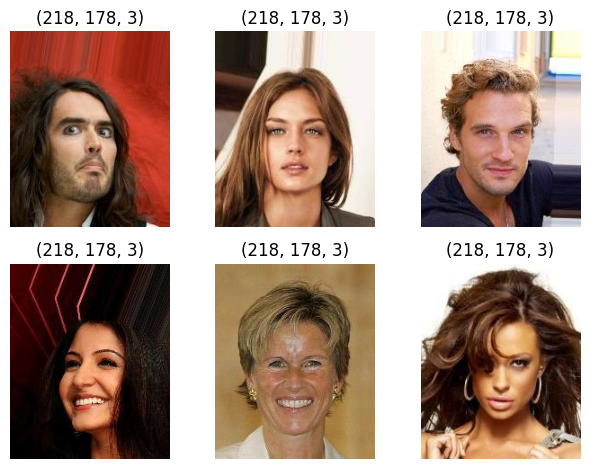

In [150]:
# Display Multiple Sample Images.
for i in range(0, 6):
    plt.subplot(2, 3, i+1)

    # Read an Image.
    img = cv2.imread(IMG_PATH + '/' + df["image_id"][i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display Image.
    plt.imshow(img)
    plt.title(img.shape)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [151]:
# Get the category distribution.
category_count = df["Gender"].value_counts()
print(category_count)

higher_category = list(category_count.index)[0]

Female    1442
Male      1058
Name: Gender, dtype: int64


In [152]:
# Get the indices of the higher category indices images.
np.random.seed(42)
indices = df[df["Gender"] == higher_category].index
sample_size = category_count[0] - category_count[1]

# Drop the extra rows of female images to fix class imbalance problem.
drop_sample = np.random.choice(indices, sample_size, replace = False)
df = df.drop(drop_sample, axis = "index")

<Axes: >

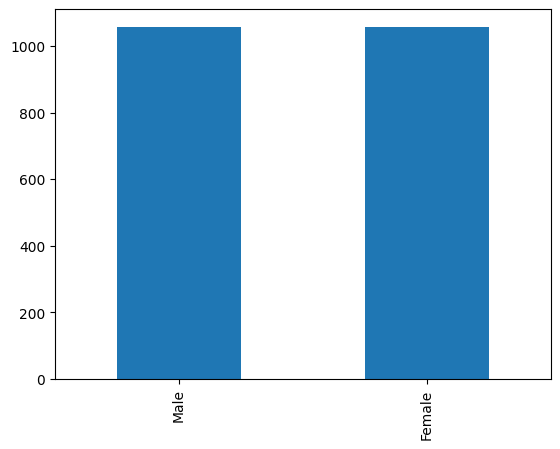

In [153]:
df["Gender"].value_counts().plot.bar()

In [154]:
train_df, test_df = train_test_split(df, test_size=0.2)
test_df, validation_df = train_test_split(test_df, test_size=0.33)

In [155]:
print("Total Train Sample Images : ", len(train_df))
print("Total Test Sample Images : ", len(test_df))
print("Total Validation Sample Images : ", len(validation_df))

Total Train Sample Images :  1692
Total Test Sample Images :  284
Total Validation Sample Images :  140


In [156]:
IMAGE_SIZE = (218, 178)
BATCH_SIZE = 16

In [157]:
# Generate Train Images Data Generator.
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    IMG_PATH + "/",
    x_col='image_id',
    y_col='Gender',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 1692 validated image filenames belonging to 2 classes.


In [158]:
# Generate Validation Images Data Generator.
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validation_df,
    IMG_PATH + "/",
    x_col='image_id',
    y_col='Gender',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 140 validated image filenames belonging to 2 classes.


In [159]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df,
    IMG_PATH + "/",
    x_col='image_id',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 284 validated image filenames.


In [160]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [161]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=IMAGE_SIZE + (3,))

In [162]:
base_model.trainable = False
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 218, 178, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_212 (Conv2D)            (None, 108, 88, 32)  864         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_212 (Batch  (None, 108, 88, 32)  96         ['conv2d_212[0][0]']             
 Normalization)                                                                                   
                                                                                       

In [163]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D

In [164]:
# Building Model
model=Sequential()
model.add(base_model)
#model.add(layers.Dropout(.2))

model.add(Conv2D(512, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Dropout(.1))
model.add(Conv2D(256, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Dropout(.1))
model.add(Conv2D(128, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Dropout(.1))
model.add(Conv2D(64, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Dropout(.1))
model.add(Conv2D(32, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(16, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(8, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(4, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,strides=(2,2), padding='same'))

# Add new layers
model.add(Flatten())
model.add(Dense(256 , activation='relu'))
model.add(layers.Dropout(.2))
model.add(Dense(256 , activation='relu'))
model.add(layers.Dropout(.2))
model.add(Dense(64, activation='relu'))
model.add(layers.Dropout(.2))
model.add(Dense(32, activation='relu'))
model.add(layers.Dropout(.2))
model.add(Dense(32, activation='relu'))
model.add(layers.Dropout(.2))
model.add(Dense(2, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 4, 2048)        21802784  
                                                                 
 conv2d_306 (Conv2D)         (None, 5, 4, 512)         9437696   
                                                                 
 batch_normalization_306 (Ba  (None, 5, 4, 512)        2048      
 tchNormalization)                                               
                                                                 
 dropout_27 (Dropout)        (None, 5, 4, 512)         0         
                                                                 
 conv2d_307 (Conv2D)         (None, 5, 4, 256)         1179904   
                                                                 
 batch_normalization_307 (Ba  (None, 5, 4, 256)        1024      
 tchNormalization)                                    

In [165]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 4, 2048)        21802784  
                                                                 
 conv2d_306 (Conv2D)         (None, 5, 4, 512)         9437696   
                                                                 
 batch_normalization_306 (Ba  (None, 5, 4, 512)        2048      
 tchNormalization)                                               
                                                                 
 dropout_27 (Dropout)        (None, 5, 4, 512)         0         
                                                                 
 conv2d_307 (Conv2D)         (None, 5, 4, 256)         1179904   
                                                                 
 batch_normalization_307 (Ba  (None, 5, 4, 256)        1024      
 tchNormalization)                                    

In [166]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='model1.hdf5', # load
                               verbose=1, save_best_only=True)

In [167]:
patience = 4
verbose = 1
factor = 0.5
min_lr = 0.0001

earlystop = EarlyStopping(patience=10)
lrd = ReduceLROnPlateau(monitor = 'val_accuracy',
                        patience = patience,
                        verbose = verbose ,
                        factor = factor,
                        min_lr = min_lr)

#mcp = ModelCheckpoint('model.h5')

#callbacks = EarlyStopping(verbose=verbose, patience=patience)

callbacks = [earlystop, lrd, checkpointer]

In [168]:
history = model.fit(train_generator, validation_data = validation_generator
                        , validation_steps=len(validation_df)//BATCH_SIZE
                        ,steps_per_epoch=len(train_df)//BATCH_SIZE,
                        epochs=10, verbose = 1, callbacks=callbacks)

Epoch 1/10
105/105 [==============================] - ETA: 0s - loss: 0.4658 - accuracy: 0.7936
Epoch 1: val_loss improved from inf to 0.60641, saving model to model1.hdf5
105/105 [==============================] - 39s 250ms/step - loss: 0.4658 - accuracy: 0.7936 - val_loss: 0.6064 - val_accuracy: 0.8438 - lr: 0.0010
Epoch 2/10
105/105 [==============================] - ETA: 0s - loss: 0.3199 - accuracy: 0.8729
Epoch 2: val_loss improved from 0.60641 to 0.26948, saving model to model1.hdf5
105/105 [==============================] - 23s 215ms/step - loss: 0.3199 - accuracy: 0.8729 - val_loss: 0.2695 - val_accuracy: 0.9062 - lr: 0.0010
Epoch 3/10
105/105 [==============================] - ETA: 0s - loss: 0.2916 - accuracy: 0.8944
Epoch 3: val_loss did not improve from 0.26948
105/105 [==============================] - 22s 205ms/step - loss: 0.2916 - accuracy: 0.8944 - val_loss: 0.2800 - val_accuracy: 0.9219 - lr: 0.0010
Epoch 4/10
105/105 [==============================] - ETA: 0s - loss

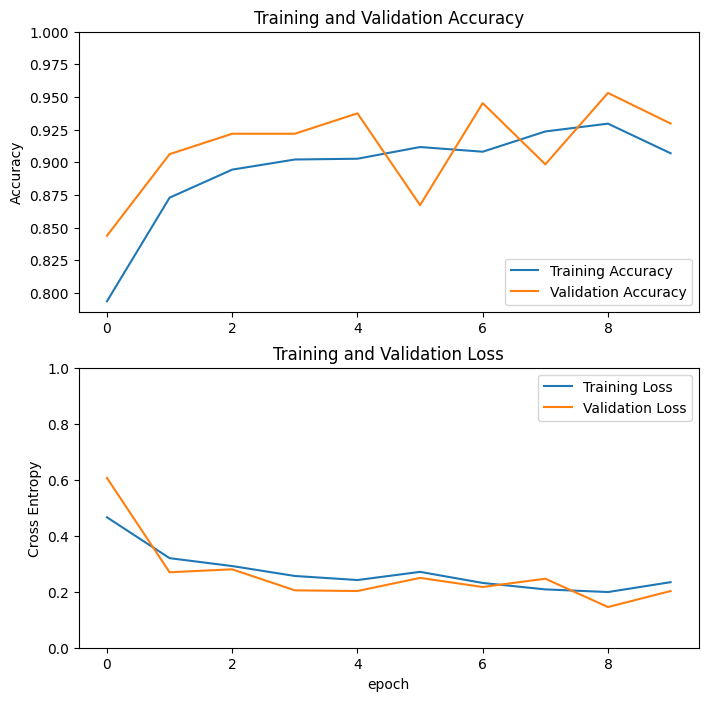

In [169]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [170]:
model.load_weights('model1.hdf5')

In [171]:
predict = model.predict(test_generator, steps=np.ceil(len(test_df)/BATCH_SIZE))

18/18 [==============================] - 2s 49ms/step


In [172]:
prediction = predict.argmax(axis=-1)
test_df['Prediction'] = ["Male" if ele == 1 else "Female" for ele in prediction]

In [173]:
test_df

,image_id,Gender,Prediction
119,071160.jpg,Female,Female
2406,162337.jpg,Female,Male
914,060475.jpg,Male,Male
1230,102227.jpg,Male,Male
976,148106.jpg,Male,Male
...,...,...,...
1461,107642.jpg,Female,Female
780,187640.jpg,Male,Male
612,152534.jpg,Male,Male
2334,140047.jpg,Male,Male


In [174]:
labels = ['Male','Female']
cm = confusion_matrix(test_df['Gender'], test_df["Prediction"], labels= labels)
cm

array([[131,   5],
       [ 24, 124]])

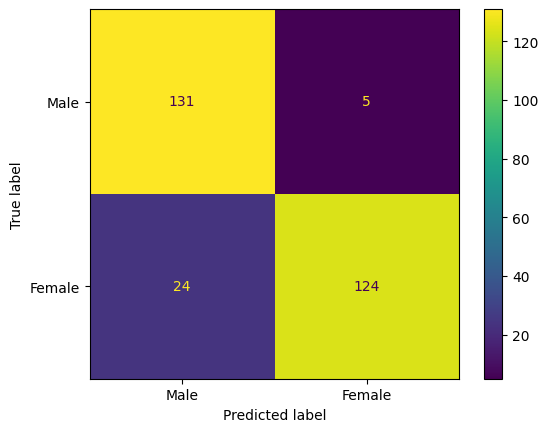

In [175]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp.plot()
plt.show()

In [176]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

print(classification_report(test_df['Gender'], test_df["Prediction"], labels= labels))

              precision    recall  f1-score   support

        Male       0.85      0.96      0.90       136
      Female       0.96      0.84      0.90       148

    accuracy                           0.90       284
   macro avg       0.90      0.90      0.90       284
weighted avg       0.91      0.90      0.90       284



In [177]:
gender_target = {0: 'Female', 1: 'Male'}

def img_to_display(filename):
    # inspired on this kernel:
    # https://www.kaggle.com/stassl/displaying-inline-images-in-pandas-dataframe
    # credits to stassl :)

    i = Image.open(filename)
    i.thumbnail((200, 200), Image.LANCZOS)

    with BytesIO() as buffer:
        i.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()


def display_result(filename, prediction, target):
    '''
    Display the results in HTML

    '''

    gender = 'Male'
    gender_icon = "https://i.imgur.com/nxWan2u.png"

    if prediction[1] <= 0.5:
        gender_icon = "https://i.imgur.com/oAAb8rd.png"
        gender = 'Female'

    display_html = '''
    <div style="overflow: auto;  border: 2px solid #D8D8D8;
        padding: 5px; width: 420px;" >
        <img src="data:image/jpeg;base64,{}" style="float: left;" width="200" height="200">
        <div style="padding: 10px 0px 0px 20px; overflow: auto;">
            <img src="{}" style="float: left;" width="40" height="40">
            <h3 style="margin-left: 50px; margin-top: 2px;">{}</h3>
            <p style="margin-left: 50px; margin-top: -6px; font-size: 12px">{} prob.</p>
            <p style="margin-left: 50px; margin-top: -16px; font-size: 12px">Real Target: {}</p>
            <p style="margin-left: 50px; margin-top: -16px; font-size: 12px">Filename: {}</p>
        </div>
    </div>
    '''.format(img_to_display(filename)
               , gender_icon
               , gender
               , "{0:.2f}%".format(round(max(prediction)*100,2))
               , gender_target[target]
               , filename.split('/')[-1]
               )

    display(HTML(display_html))

In [178]:
def gender_prediction(filename):
    '''
    predict the gender

    input:
        filename: str of the file name

    return:
        array of the prob of the targets.

    '''

    im = cv2.imread(filename)
    im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (178, 218)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis =0)

    # prediction
    result = model.predict(im)
    prediction = np.argmax(result)

    return result

1/1 [==============================] - 0s 35ms/step



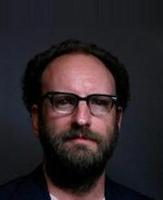

1/1 [==============================] - 0s 33ms/step



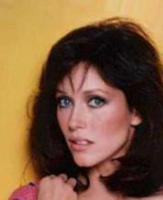

1/1 [==============================] - 0s 36ms/step



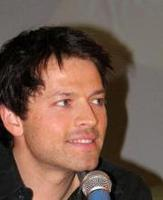

1/1 [==============================] - 0s 34ms/step



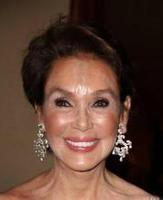

1/1 [==============================] - 0s 50ms/step



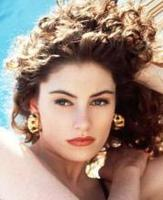

1/1 [==============================] - 0s 46ms/step



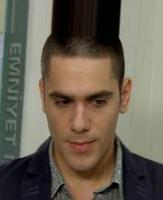

In [179]:
df_to_test = DF_PARTITION[(DF_PARTITION['partition'] == 2)].sample(6)

for index, target in df_to_test.iterrows():
    result = gender_prediction(IMG_PATH + index)

    #display result
    display_result(IMG_PATH + index, result[0], target['Male'])

In [180]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [181]:
BASIC_PATH = "/content/drive/MyDrive/AI_Dataset/"


1/1 [==============================] - 0s 90ms/step
[0.13565199 1.        ]
This is a male


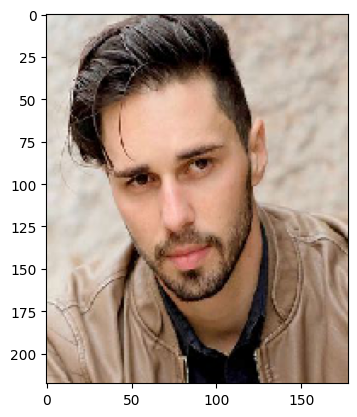

In [182]:
import numpy as np

import keras.utils as image
#  images test 1
path_testmodel = '/content/drive/MyDrive/AI_Dataset/testmodel/pria1.jpg'
imge = image.load_img(path_testmodel, target_size=IMAGE_SIZE)
X = image.img_to_array(imge)
X = np.expand_dims(X, axis=0)

images = np.vstack([X])
classes = model.predict(images, batch_size=1)
print(classes[0])
if classes.all()>0.5:
    print("This is a male")
else:
    print( "This  is a female")
plt.imshow(imge)


1/1 [==============================] - 0s 32ms/step
[0.06587029 1.        ]
This  is a female


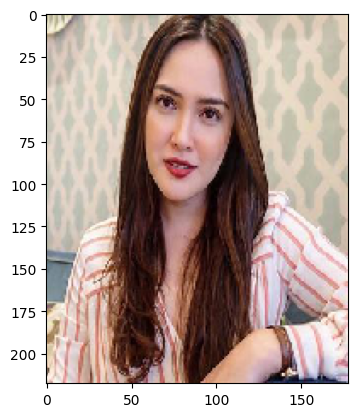

In [183]:
import numpy as np

import keras.utils as image
#  images test 2
path_testmodel = '/content/drive/MyDrive/AI_Dataset/testmodel/sandi.jpg'
imge = image.load_img(path_testmodel, target_size=IMAGE_SIZE)
X = image.img_to_array(imge)
X = np.expand_dims(X, axis=0)

images = np.vstack([X])
classes = model.predict(images, batch_size=1)
print(classes[0])
if classes.all()<0.5:
    print("This is a male")
else:
    print( "This  is a female")
plt.imshow(imge)



1/1 [==============================] - 0s 58ms/step
[0.01204473 0.9900643 ]
This is a male


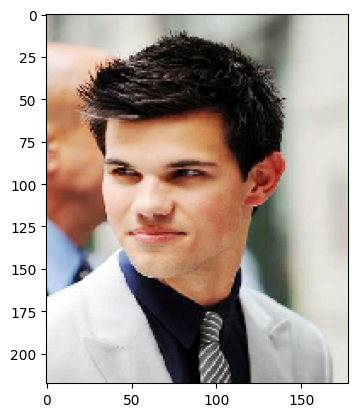

In [134]:
import numpy as np

import keras.utils as image
#  images test 2
path_testmodel = '/content/drive/MyDrive/AI_Dataset/testmodel/pria2.jpg'
imge = image.load_img(path_testmodel, target_size=IMAGE_SIZE)
X = image.img_to_array(imge)
X = np.expand_dims(X, axis=0)

images = np.vstack([X])
classes = model.predict(images, batch_size=1)
print(classes[0])
if classes.all()>0.5:
    print("This is a male")
else:
    print( "This  is a female")
plt.imshow(imge)
